## This is a demo code of Mask RCNN from Webcam
The code reference below references as a demo to leverage Mask RCNN to perform real time webcam oboject detection and instance segmentation.

### Reference:
1. Original paper: Kaiming He, Georgia Gkioxari, Piotr Doll´ar, Ross Girshick, Mask RCNN: https://arxiv.org/pdf/1703.06870.pdf 
2. Matterport Inc., An implementation of Mask R-CNN for object detection and instance segmentation on Keras and TensorFlow. https://github.com/matterport/Mask_RCNN
3. markjay4k, Video input for Mask RCNN: https://github.com/markjay4k/Mask-RCNN-series/blob/master/Mask_RCNN%20Install%20Instructions.ipynb
4. Increasing webcam FPS with Python and OpenCV, https://www.pyimagesearch.com/2015/12/21/increasing-webcam-fps-with-python-and-opencv/
5. Webcam based image processing in iPython notebooks https://medium.com/@neotheicebird/webcam-based-image-processing-in-ipython-notebooks-47c75a022514

In [16]:
%matplotlib inline
# import the necessary packages
import numpy as np
from threading import Thread
import datetime
import cv2
import matplotlib.pyplot as plt
from IPython import display
import signal
import os
import sys
import coco
import utils
import model as modellib

### Class definition for FPS calculation and webcam threading.

#### Reference
1. Adrian Rosebrock, imutils, https://github.com/jrosebr1/imutils/tree/master/imutils/video

In [17]:
class FPS:
    def __init__(self):
        # store the start time, end time, and total number of frames
        # that were examined between the start and end intervals
        self._start = None
        self._end = None
        self._numFrames = 0

    def start(self):
        # start the timer
        self._start = datetime.datetime.now()
        return self

    def stop(self):
        # stop the timer
        self._end = datetime.datetime.now()

    def update(self):
        # increment the total number of frames examined during the
        # start and end intervals
        self._numFrames += 1

    def elapsed(self):
        # return the total number of seconds between the start and
        # end interval
        return (self._end - self._start).total_seconds()

    def fps(self):
        # compute the (approximate) frames per second
        return self._numFrames / self.elapsed()

class WebcamVideoStream:
    def __init__(self, src=0):
        # initialize the video camera stream and read the first frame
        # from the stream
        self.stream = cv2.VideoCapture(src)
        (self.grabbed, self.frame) = self.stream.read()

        # initialize the variable used to indicate if the thread should
        # be stopped
        self.stopped = False

    def start(self):
        # start the thread to read frames from the video stream
        t = Thread(target=self.update, args=())
        t.daemon = True
        t.start()
        return self

    def update(self):
        # keep looping infinitely until the thread is stopped
        while True:
            # if the thread indicator variable is set, stop the thread
            if self.stopped:
                return

            # otherwise, read the next frame from the stream
            (self.grabbed, self.frame) = self.stream.read()

    def read(self):
        # return the frame most recently read
        return self.frame

    def stop(self):
        # indicate that the thread should be stopped
        self.stopped = True




### Major display function definitions

In [18]:
def random_colors(N):
    np.random.seed(1)
    colors = [tuple(255 * np.random.rand(3)) for _ in range(N)]
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """apply mask to image"""
    for n, c in enumerate(color):
        image[:, :, n] = np.where(
            mask == 1,
            image[:, :, n] * (1 - alpha) + alpha * c,
            image[:, :, n]
        )
    return image


def display_instances(image, boxes, masks, ids, names, scores):
    """
        take the image and results and apply the mask, box, and Label
    """
    n_instances = boxes.shape[0]
    colors = random_colors(n_instances)

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i, color in enumerate(colors):
        if not np.any(boxes[i]):
            continue

        y1, x1, y2, x2 = boxes[i]
        label = names[ids[i]]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        mask = masks[:, :, i]

        image = apply_mask(image, mask, color)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        image = cv2.putText(
            image, caption, (x1+2, y1-7), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2
        )

    return image


### Define a signal function to capture the interruption.

In [19]:
def signal_handler(signal, frame):
    # KeyboardInterrupt detected, exiting
    global is_interrupted
    is_interrupted = True

## Main program

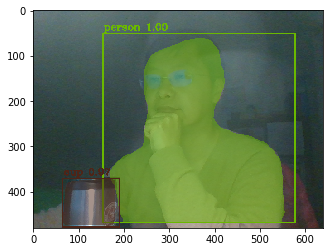

[INFO] elasped time: 86.46
[INFO] approx. FPS: 0.07


In [21]:
if __name__ == '__main__':
    """
        test everything
    """
    ROOT_DIR = os.getcwd()
    MODEL_DIR = os.path.join(ROOT_DIR, "logs")
    COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
    if not os.path.exists(COCO_MODEL_PATH):
        utils.download_trained_weights(COCO_MODEL_PATH)

    class InferenceConfig(coco.CocoConfig):
        GPU_COUNT = 1
        IMAGES_PER_GPU = 1

    config = InferenceConfig()
    config.display()

    model = modellib.MaskRCNN(
        mode="inference", model_dir=MODEL_DIR, config=config
    )
    model.load_weights(COCO_MODEL_PATH, by_name=True)
    class_names = [
        'BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
        'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
        'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
        'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
        'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
        'kite', 'baseball bat', 'baseball glove', 'skateboard',
        'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
        'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
        'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
        'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
        'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
        'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
        'teddy bear', 'hair drier', 'toothbrush'
    ]

    # created a *threaded* video stream, allow the camera sensor to warmup,
    # and start the FPS counter
    print("[INFO] sampling THREADED frames from webcam...")
    vs = WebcamVideoStream(src=0).start()
    fps = FPS().start()
    frame = vs.read()
    
    signal.signal(signal.SIGINT, signal_handler)
    is_interrupted = False
    
    # loop over some frames...this time using the threaded stream
    while fps._numFrames < 50:
        # grab the frame from the threaded video stream
        frame = vs.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # check to see if the frame should be displayed to our screen
        results = model.detect([frame], verbose=0)
        r = results[0]
        frame = display_instances(
                frame, r['rois'], r['masks'], r['class_ids'], class_names, r['scores']
        )
        # check to see if the frame should be displayed to our screen
        
        plt.imshow(frame)
        display.clear_output(wait=True)

        try:    # Avoids a NotImplementedError caused by `plt.pause`
            plt.pause(0.05) # the pause time
        except Exception:
            pass
        # update the FPS counter
        fps.update()
        if is_interrupted or cv2.waitKey(1) == 27: #escape key to exit while loop
            break
    # stop the timer and display FPS information
    fps.stop()
    print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
    print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))
 
    # do a bit of cleanup
    cv2.destroyAllWindows()
    vs.stop()